# ニューラルネットワーク (Neural Network)

ひらがな判定をする。72種類

ライブラリ読み込み

In [1]:
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 分類クラス数
nb_classes = 72

# データの読み込み
ary = np.load("./../data/hiragana.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32) / 15
ary.shape

# 入力データの取得
# サイズを変換する (127, 128) => (32, 32)
img_height, img_width = 32, 32

X_data = np.zeros([nb_classes * 160, img_height, img_width], dtype=np.float32)
for i in range(nb_classes * 160):
    # 画像をリサイズする
    X_data[i] = scipy.misc.imresize(ary[i], (img_height, img_width), mode='F')
Y_data = np.repeat(np.arange(nb_classes), 160)

del ary

# ニューラルネットワークの入力にあわせるため、2次元を1次元にする
# (11520, 32, 32) => (11520, 1024) # 1024 = 32*32
X_data = X_data.reshape(X_data.shape[0], img_height * img_width)

# データセットをトレーニングセットとCVに分ける（8:2)
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2)

# one-hot vectorに変換する
def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int').ravel()
    if not nb_classes:
        nb_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, nb_classes))
    categorical[np.arange(n), y] = 1
    return categorical

Y_train0_old = Y_train[0]
Y_train = to_categorical(Y_train, nb_classes)
Y_val = to_categorical(Y_val, nb_classes)

# 表示
print('train set:', X_train.shape, Y_train.shape)
print('cv set:', X_val.shape, Y_val.shape)

train set: (9216, 1024) (9216, 72)
cv set: (2304, 1024) (2304, 72)


## モデルの作成

```
input:      [batch_size, 1024(32x32))]
hidden:   weights(1024x1024) + bias(1024) => relu
output:   weights(1024x72) + bias(72) => softmax, cross_entropy
```

グラフの入力を定義

In [3]:
X = tf.placeholder(tf.float32, [None, 1024]) # 入力数: 32x32 = 1,024
y = tf.placeholder(tf.float32, [None, 72]) # 分類するクラス数: 72

モデルの重み$W$とバイアス$b$の変数を定義

In [4]:
# 出力層
W_o = tf.Variable(tf.truncated_normal([1024, 72]))
b_o = tf.Variable(tf.truncated_normal([72])) 

出力層の計算

In [5]:
logits = tf.add(tf.matmul(X, W_o), b_o)

損失の計算（softmaxをしてクロスエントロピーでコストを計算する)

In [6]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))

最適化を勾配降下法で定義学習率: 0.5

In [7]:
update = tf.train.GradientDescentOptimizer(0.5).minimize(cost)

精度測定の定義

In [8]:
# 正しいかの予測
y_pred = tf.nn.softmax(logits)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

## トレーニング

In [9]:
train_hist = []
val_hist = []
batch_size = 256

with tf.Session() as sess:
    # Variableの初期化
    sess.run(tf.initialize_all_variables())

    # 3000回トレーニングする
    for epoch in range(3000):
        avg_cost = 0.0
        nb_batch = int(X_train.shape[0] / batch_size) # バッチループ数: 11520 / 100 = 115.2
        for i in range(nb_batch):
            start =  i * batch_size
            end = start + batch_size
            batch_xs, batch_ys = X_train[start:end], Y_train[start:end]
            _, cost_v = sess.run([update, cost], feed_dict={X: batch_xs, y: batch_ys})
            avg_cost += cost_v / nb_batch
        
        # 100エポックごとに進捗を表示
        if (epoch+1) % 100 == 0:
            train_acc = accuracy.eval(feed_dict={X: batch_xs, y: batch_ys})
            val_acc = accuracy.eval(feed_dict={X: X_val, y: Y_val})
            train_hist.append(train_acc)
            val_hist.append(val_acc)
            print("Epoch: {:04d}, cost={:.9f}, train acc={:.5f}, val acc={:.5f}".format(
                        (epoch+1), avg_cost, train_acc, val_acc))
            
    print("Complete")

Epoch: 0100, cost=2.010739449, train acc=0.56250, val acc=0.47135
Epoch: 0200, cost=1.541207575, train acc=0.64062, val acc=0.56424
Epoch: 0300, cost=1.330731872, train acc=0.68359, val acc=0.59852
Epoch: 0400, cost=1.202124602, train acc=0.69531, val acc=0.61762
Epoch: 0500, cost=1.112130806, train acc=0.71875, val acc=0.63628
Epoch: 0600, cost=1.043984849, train acc=0.72656, val acc=0.64627
Epoch: 0700, cost=0.989638183, train acc=0.73047, val acc=0.65321
Epoch: 0800, cost=0.944699691, train acc=0.75000, val acc=0.65799
Epoch: 0900, cost=0.906546031, train acc=0.75391, val acc=0.66319
Epoch: 1000, cost=0.873497503, train acc=0.75781, val acc=0.66233
Epoch: 1100, cost=0.844418839, train acc=0.78125, val acc=0.66233
Epoch: 1200, cost=0.818509306, train acc=0.78906, val acc=0.66493
Epoch: 1300, cost=0.795183930, train acc=0.79688, val acc=0.66536
Epoch: 1400, cost=0.774002807, train acc=0.80469, val acc=0.66580
Epoch: 1500, cost=0.754627364, train acc=0.81641, val acc=0.66753
Epoch: 160

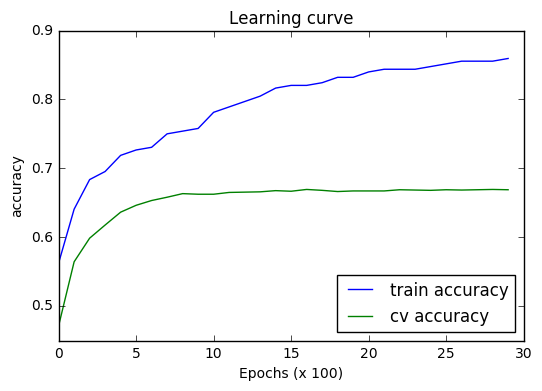

In [10]:
# 学習曲線を引く
xlin = range(0, len(train_hist))
plt.plot(xlin, train_hist, color='blue', label='train accuracy')
plt.plot(xlin, val_hist, color='green', label='cv accuracy')
plt.title('Learning curve')
plt.xlabel('Epochs (x 100)')
plt.ylabel('accuracy')
plt.legend( ('train accuracy', 'cv accuracy'), loc='lower right')
plt.show()